# Лабораторная работа 2: Искусственный нейрон и перцептрон 

 ## 1. Импорт библиотек и константы

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Константы
SIZE = 1000
SEED = 45
EPOCHS = 100
LEARNING_RATE = 0.01

np.random.seed(SEED)

## 2. Реализация функций активации (Задание 1)

In [41]:
def identity(x):
    return x

def identity_deriv(x):
    return np.ones_like(x)

def binary_step(x):
    return np.where(x >= 0, 1, 0)

def binary_step_deriv(x):
    return np.ones_like(x)

# 3. Сигмоида (Sigmoid)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    f = sigmoid(x)
    return f * (1 - f)

# 4. Гиперболический тангенс (Tanh)
def tanh(x):
    return np.tanh(x)

def tanh_deriv(x):
    return 1 - np.tanh(x)**2

# 5. ReLU (с модификацией для обучения)
def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):

    return np.where(x > 0, 1, 0.1)

ACTIVATIONS = {
    'identity': (identity, identity_deriv),
    'step': (binary_step, binary_step_deriv),
    'sigmoid': (sigmoid, sigmoid_deriv),
    'tanh': (tanh, tanh_deriv),
    'relu': (relu, relu_deriv)
}

## 3. Реализация класса Перцептрон

In [42]:
class Perceptron:
    def __init__(self, input_dim, activation_name='step', lr=LEARNING_RATE):
        self.weights = np.random.randn(input_dim)
        # Инициализируем bias значением 0.5, чтобы повысить шанс попадания
        # в активную зону ReLU на старте
        self.bias = 0.5
        self.lr = lr
        
        if activation_name not in ACTIVATIONS:
            raise ValueError(f"Неизвестная функция: {activation_name}")
            
        self.act_func, self.act_deriv = ACTIVATIONS[activation_name]
        self.name = activation_name

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return self.act_func(linear_output)

    def train(self, X, y, epochs=EPOCHS):
        loss_history = []
        
        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(len(X)):
                # 1. Прямой проход
                linear_out = np.dot(X[i], self.weights) + self.bias
                y_pred = self.act_func(linear_out)
                
                # 2. Ошибка
                error = y[i] - y_pred
                
                # 3. Градиент
                grad = error * self.act_deriv(linear_out)
                
                # 4. Обновление весов
                self.weights += self.lr * grad * X[i]
                self.bias += self.lr * grad
                
                epoch_loss += error ** 2
            
            loss_history.append(epoch_loss / len(X))
            
        return loss_history


## 4. Генерация данных и эксперименты (Задание 2)

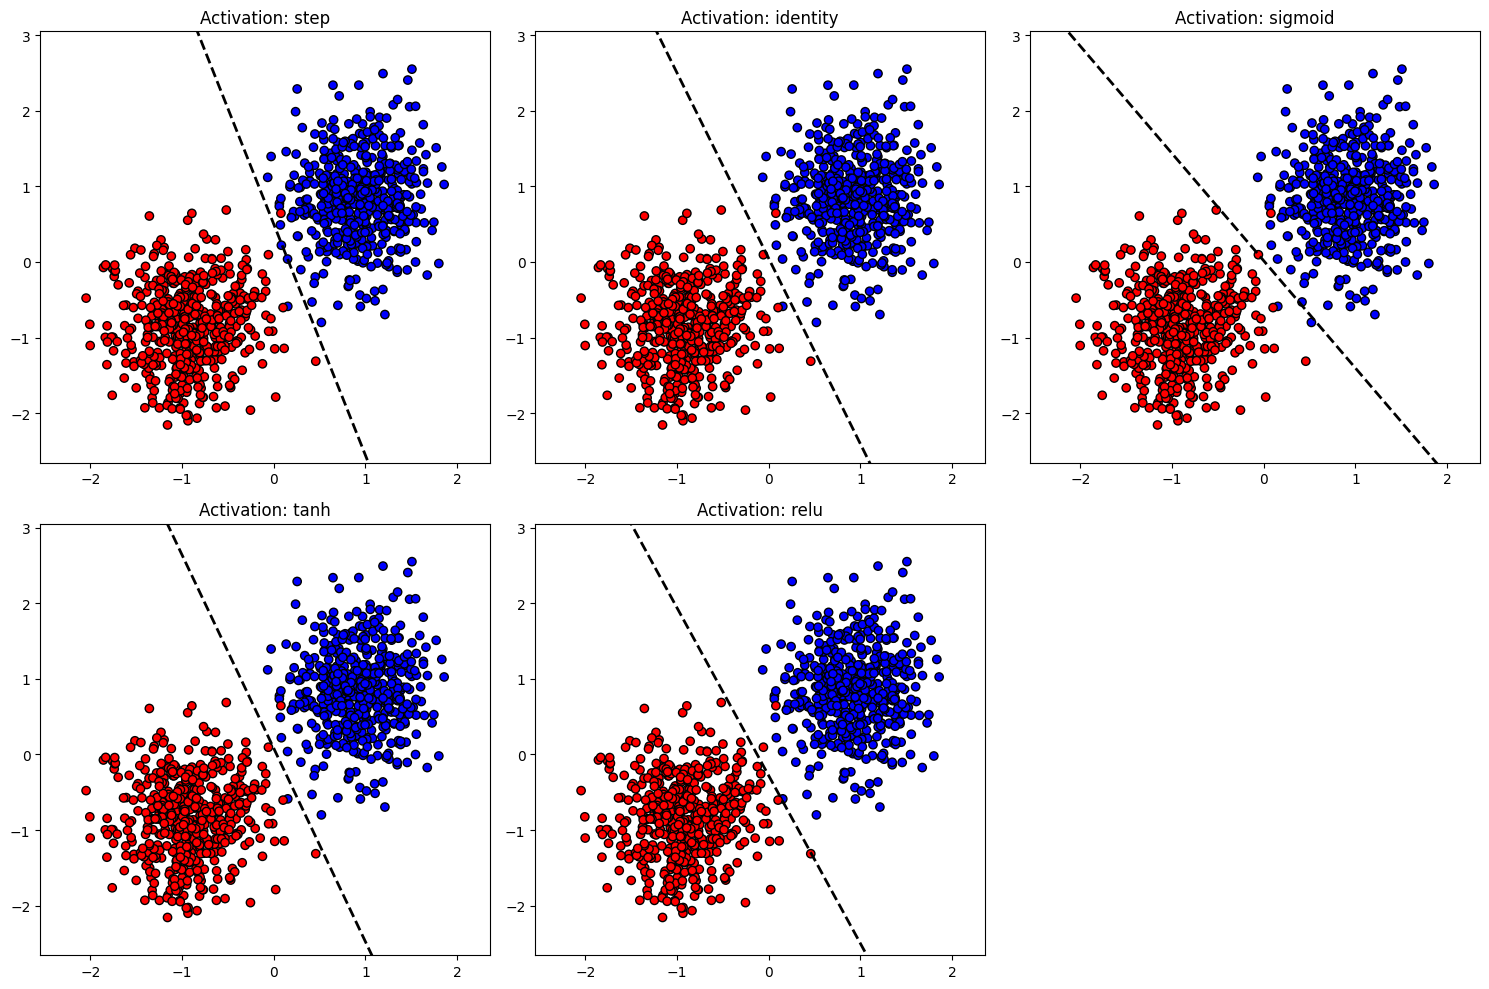

In [43]:
X, y = make_blobs(n_samples=SIZE, centers=2, n_features=2, random_state=SEED, cluster_std=3.0)

# Нормализация данных (критически важно для сходимости)
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Список функций для проверки
activation_list = ['step', 'identity', 'sigmoid', 'tanh', 'relu']

plt.figure(figsize=(15, 10))

for idx, act_name in enumerate(activation_list):
    # Настройка параметров под конкретную функцию
    current_lr = LEARNING_RATE
    y_train = y.copy()
    
    # Специфичные настройки
    if act_name == 'step':
        current_lr = 0.1
    elif act_name == 'tanh':
        # Tanh работает в диапазоне [-1, 1], меняем метки 0 -> -1
        y_train = np.where(y == 0, -1, 1)
    
    # Инициализация и обучение
    p = Perceptron(input_dim=2, activation_name=act_name, lr=current_lr)
    losses = p.train(X, y_train, epochs=EPOCHS)
    
    # --- Визуализация ---
    plt.subplot(2, 3, idx + 1)
    plt.title(f"Activation: {act_name}")
    
    # Точки
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k')
    
    # Построение разделяющей прямой
    # y = -(bias - threshold + w1*x) / w2
    
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    
    if p.weights[1] != 0:
        x_vals = np.array([x_min, x_max])
        
        # Определяем порог разделения (Threshold) для визуализации
        boundary_threshold = 0
        if act_name in ['identity', 'relu']:
            # Identity и ReLU (MSE loss) пытаются приблизить значения 0 и 1.
            # Лучшая граница проходит посередине, то есть по уровню 0.5
            boundary_threshold = 0.5
        
        y_vals = -(p.bias - boundary_threshold + p.weights[0] * x_vals) / p.weights[1]
        plt.plot(x_vals, y_vals, 'k--', lw=2, label='Boundary')
    
    plt.xlim(x_min, x_max)
    plt.ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)

plt.tight_layout()
plt.show()

## 5. Ответы на вопросы (Задание 3)

**1. Что делает функция активации в искусственном нейроне?**
Функция активации преобразует взвешенную сумму входов в выходной сигнал. В классическом перцептроне (Step) она работает как переключатель (0 или 1), а в современных сетях добавляет нелинейность, позволяя решать более сложные задачи.

**2. Чем отличается искусственный нейрон от однослойного перцептрона?**
Искусственный нейрон — это структурная единица. Однослойный перцептрон — это архитектура сети, состоящая из одного слоя таких нейронов (часто с пороговой функцией активации).

**3. Какое правило используется для обучения перцептрона?**
Используется правило коррекции ошибки (для пороговой функции) или правило Дельты (для дифференцируемых функций): $w_{new} = w_{old} + \eta \cdot (y - \hat{y}) \cdot f'(z) \cdot x$.

**4. Почему однослойный перцептрон не может решить задачу XOR?**
Потому что XOR — это линейно неразделимая задача. Однослойный перцептрон умеет строить только прямые линии (гиперплоскости), а классы в XOR расположены так, что одной прямой их не разделить.

**5. Что произойдет, если изменить функцию активации с сигмоиды на ReLU?**
Будет тоже хороший результат, но:
* **"Мертвые нейроны" (Dead Neurons):** Главный недостаток ReLU. Если взвешенная сумма нейрона станет отрицательной ($z < 0$), градиент станет 0, и веса перестанут обновляться. Нейрон может "умереть" и оставаться неактивным до конца обучения.
* **Несимметричность:** ReLU несимметрична относительно нуля (выход $\ge 0$). Это может вызывать смещение градиентов и проблему "расслоения" (clustering).
* **Преимущество (Скорость):** В отличие от сигмоиды (где есть тяжелая экспонента), ReLU вычисляется мгновенно (`max(0, x)`). Также у ReLU в положительной области градиент равен 1, что решает проблему затухания градиента в глубоких сетях.